In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from IPython.display import display
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.signal

# Set matplotlib parameters for displaying graphs
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images
plt.rcParams['font.size']= 14

pd.set_option('display.max_columns', None)

In [74]:
########################################################################################################
#                                          PART 206                                                    #
########################################################################################################

# Using video timestamps, record min and sec for each trial start and trust feedback, insert into lists
# Estimate the offset between video time and BioPac time and subtract in while loop
# Printed values are the sample numbers where you should start to look for trigger onsets
# Each sample is 0.0005 seconds, we only need .01 seconds resolution, so to the nearest 20 samples

mins_201 = [1,8,13,18,23,29,33,38,42,48,53,56]
secs_201 = [58,46,10,14,25,21,36,33,25,48,1,59]

mins_202 = [1,10,15,20,25,29,34,44,49,53,58,63]
secs_202 = [4,1,27,24,40,59,35,25,2,31,34,31]

mins_203 = [2,8,15,19,25,29,34,44,49,53,58,63]
secs_203 = [28,57,22,57,7,23,12,48,16,35,20,35]

mins_204 = [1,12,16,20,25,29,36,40,44,48,52,56]
secs_204 = [59,42,37,54,41,53,30,36,5,15,7,3]

mins_205 = [2,10,17,22,28,34,40,46,51,56,62,68]
secs_205 = [13,38,17,57,48,14,26,5,29,45,40,25]

mins_206 = [4,12,17,22,27,32,36,41,46,51,55,60]
secs_206 = [11,32,24,5,0,5,59,34,44,15,53,23]

mins_207 = [2,8,13,17,22,27,32,36,41,45,49,54]
secs_207 = [52,45,17,44,23,47,15,42,10,39,43,25]

mins_208 = [2,10,17,22,27,32,36,41,45,50,55,60]
secs_208 = [8,3,4,10,13,1,32,10,49,30,18,3]

mins_209 = [2,7,12,16,20,25,29,36,39,43,47,52]
secs_209 = [4,42,20,28,56,3,4,6,59,57,49,19]

mins_210 = [2,9,15,19,23,28,32,36,40,43,47,52]
secs_210 = [1,52,9,38,48,2,8,10,5,54,57,14]

mins_211 = [2,8,12,16,19,23,26,30,34,37,41,45]
secs_211 = [55,2,18,0,47,24,52,33,13,54,56,44]

mins_212 = [1,9,13,18,22,27,32,36,41,45,49,54]
secs_212 = [56,16,55,20,48,25,13,34,18,22,15,2]

mins_213 = [2,10,16,21,26,31,35,40,45,50,54,62]
secs_213 = [18,11,15,29,24,1,44,49,32,15,55,34]

mins_215 = [2,9,14,19,23,28,32,36,40,45,49,53]
secs_215 = [23,6,19,0,51,3,25,48,57,4,28,41]

In [75]:
participant_no = '215' #Change this everytime idiot

In [80]:
index = []

i=0
while i<12:
    index.append((mins_215[i]*60+secs_215[i])*2000-44580) #This number is different each subject and
    #must be found be looking at second dip
    i+=1
    
print(index)

[241420, 1047420, 1673420, 2235420, 2817420, 3321420, 3845420, 4371420, 4869420, 5363420, 5891420, 6397420]


<IPython.core.display.Javascript object>


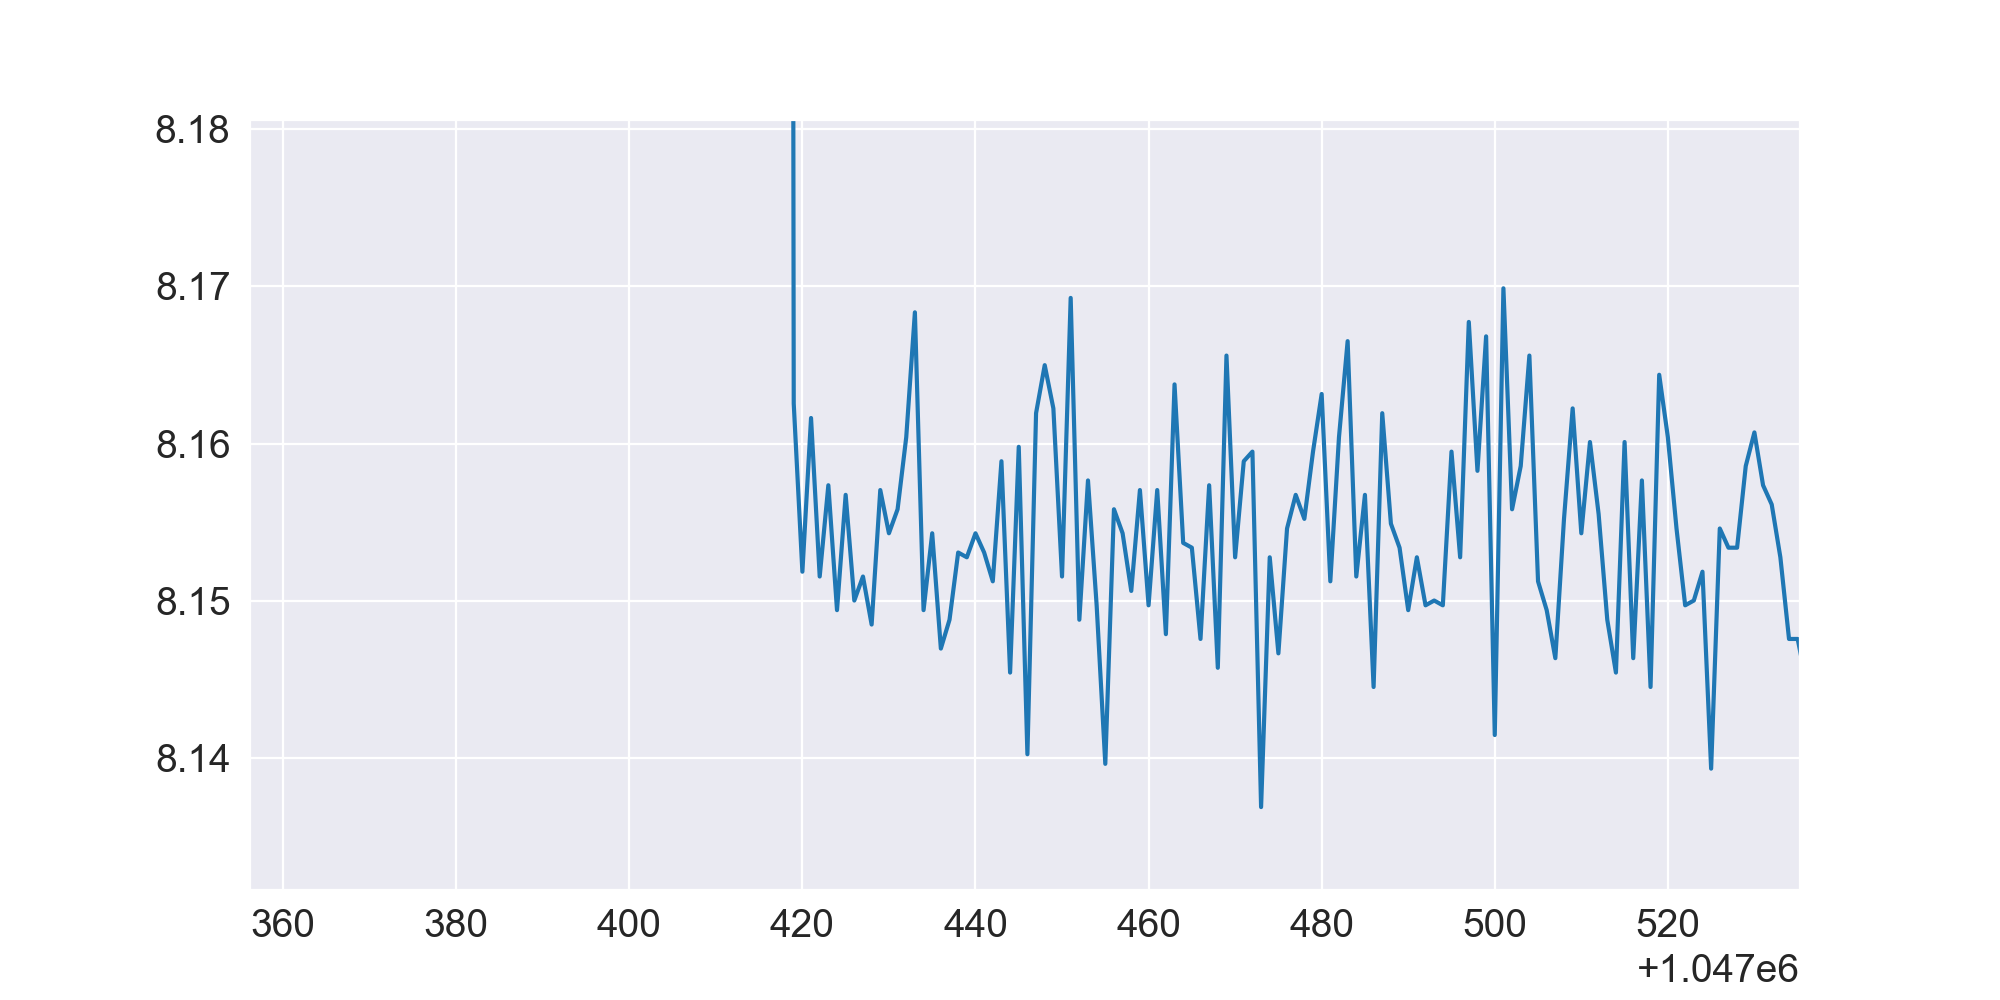

In [78]:
filename = '../data/part'+participant_no+'/part'+participant_no+'_pilot.acq'
# Read in data directly from .acq file and rename dataframe columns
# change the participant number in first line

data, sampling_rate = nk.read_acqknowledge(filename)
data = data.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})

data['TRIG'].plot()
#data['TRIG'][index[1]-300:index[1]+300].plot()



In [79]:
1092000-1047420

44580

In [81]:
end_timestamps = []
for index, value in enumerate(data['TRIG']):
    if value > 9.5:
        end_timestamps.append(index)
print(end_timestamps[::2])

[977208, 1603864, 2170832, 2726492, 3254940, 3769372, 4294953, 4803969, 5288471, 5810480, 6297947, 6784770]
